# Basic Data Types 

In this notebook, we present the different data types that are currently available in MIIT. 

In [1]:
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.image import DefaultImage, Annotation, Pointset
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
import pyimzml

## Load data and set up experiment

We start by loading all images, annotations and st data separetely. Images can be loaded with any arbitrary library (e.g. OpenCV, SKimage). Though we use SimpleITK.

In [2]:
# Load the image first as an numpy array.
reference_image_np = data=sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/reference_image.tif'))

# ...and then put it inside an DefaultImage object. Optionally, a name can be supplied which can make it easier to handle a large amount of sections.
reference_image = DefaultImage(data=reference_image_np)

In [3]:
# We do this for all the other data types.
# Annotations are placed in Annotation objects.
tissue_mask_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/tissue_mask.tif'))
tissue_mask = Annotation(data=tissue_mask_np, name='tissue_mask')

# Optionally, labels can also be loaded and included in Annotations.
histopathology_annotations_np = sitk.GetArrayFromImage(sitk.ReadImage('../data/hist/section1/labels.nii.gz'))
histopathology_annotations_np = np.moveaxis(histopathology_annotations_np, 0, 2)
with open('../data/hist/section1/labels.txt') as f:
    histopathology_labels = [x.strip() for x in f.readlines()]

histo_annotations = Annotation(data=histopathology_annotations_np, labels=histopathology_labels, name='histo_annotations')


In [4]:
# The last of the standard annotation types are Pointsets.
# We start off by loading the data with a library of our choice. Internally, pointsets are processed as dataframes, so we load them as such as well.
df = pd.read_csv('../data/hist/section1/landmarks.csv', index_col='label')
df.head(5)

,x,y
label,,
Pt-0,274.652873,1162.959041
Pt-1,284.041369,916.189951
Pt-2,578.160806,844.405786
Pt-3,572.459226,592.183008
Pt-4,841.650086,747.418153


In [5]:
# After loading successfully we can initialize a Pointset object. By definition, pointsets use 'x' and 'y' column names to determine pixel locations.
# If the dataframe uses different column names, those can be set in `x_axis` and `y_axis` arguments.
landmarks = Pointset(data=df, name='landmarks', index_col=0)

In [6]:
# Now that we have the reference image and all additional datapoints, we can build sections.

section = Section(reference_image=reference_image,
                  annotations=[tissue_mask, histo_annotations, landmarks])

In [7]:
# To make it easier get find annotations again, we have a utility function to find the data in sections.
tissue_mask_from_section = section.get_annotations_by_names('tissue_mask')

Text(0.5, 1.0, 'Reference image + landmarks')

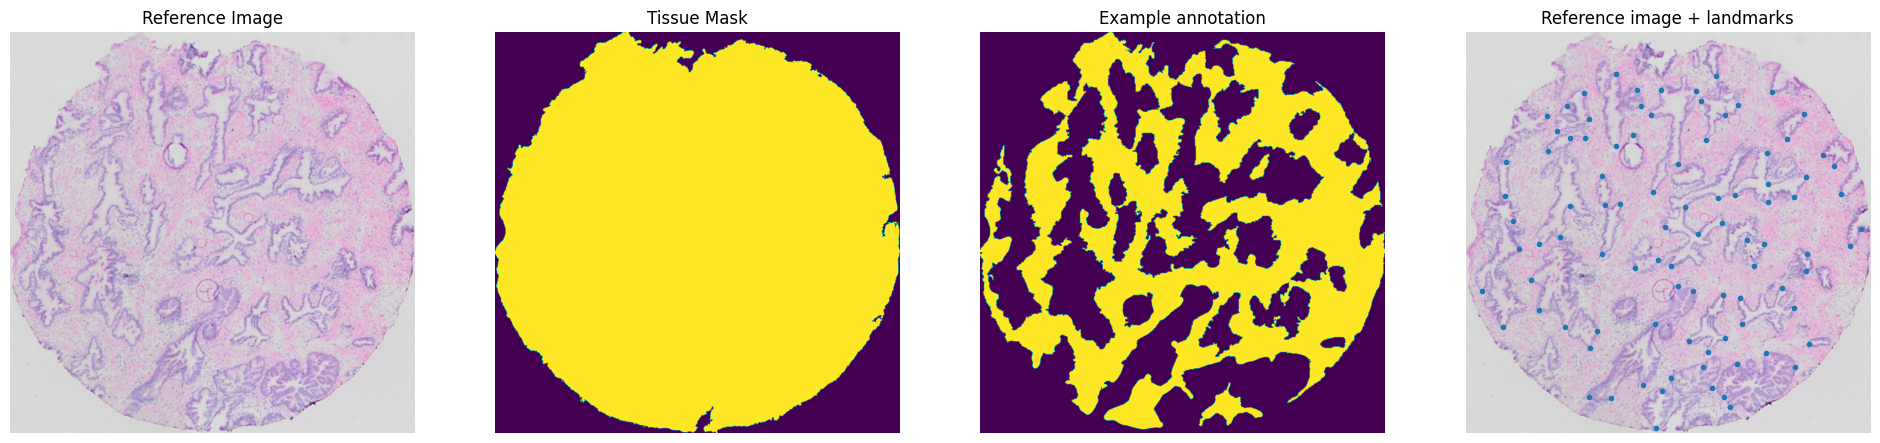

In [8]:
# We can illustrate the section.
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(tissue_mask_from_section.data)
ann = section.get_annotations_by_names('histo_annotations')
axs[1].set_title('Tissue Mask')
axs[2].imshow(ann.data[:,:,2])
axs[2].set_title('Example annotation')
axs[3].imshow(section.reference_image.data)
ps = section.get_annotations_by_names('landmarks').to_numpy()
axs[3].plot(ps[:,0], ps[:,1], '.')
axs[3].set_title('Reference image + landmarks')

### Loading Visium data

In [9]:
# Now we start with loading Visium data. We use the helper classmethod `from_spcrng` to load all the data automatically.

st_data = Visium.from_spcrng(directory='../data/visium/outs/')

Text(0.5, 1.0, 'Visium Image')

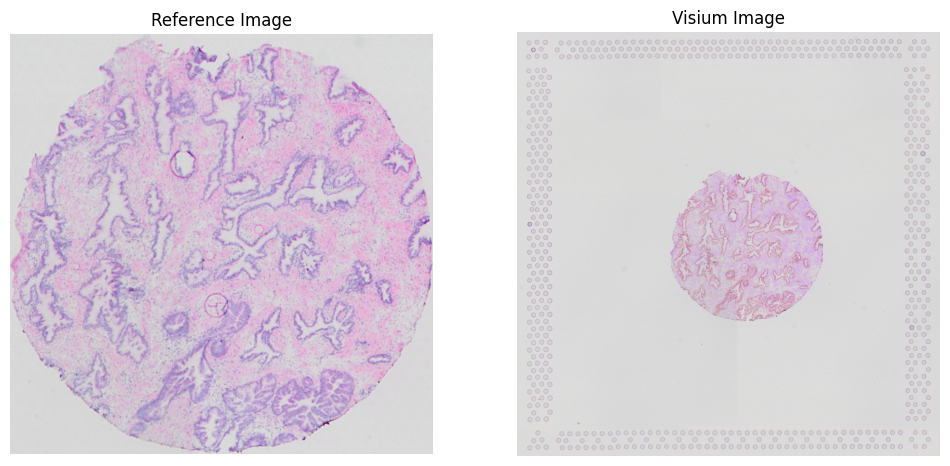

In [10]:
# We can compare both images now.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')

In [11]:
# We see that both image are differently cropped. All imaging data in a section should be spatially aligned, so we use
# a utility function for registering both images.

# `register_to_ref_image` relies on the OpenCVAffine registerer, though other registerers can be added.
warped_st_data, registered_image = register_to_ref_image(section.reference_image.data, st_data.image.data, st_data)

Text(0.5, 1.0, 'Registered Visium Image')

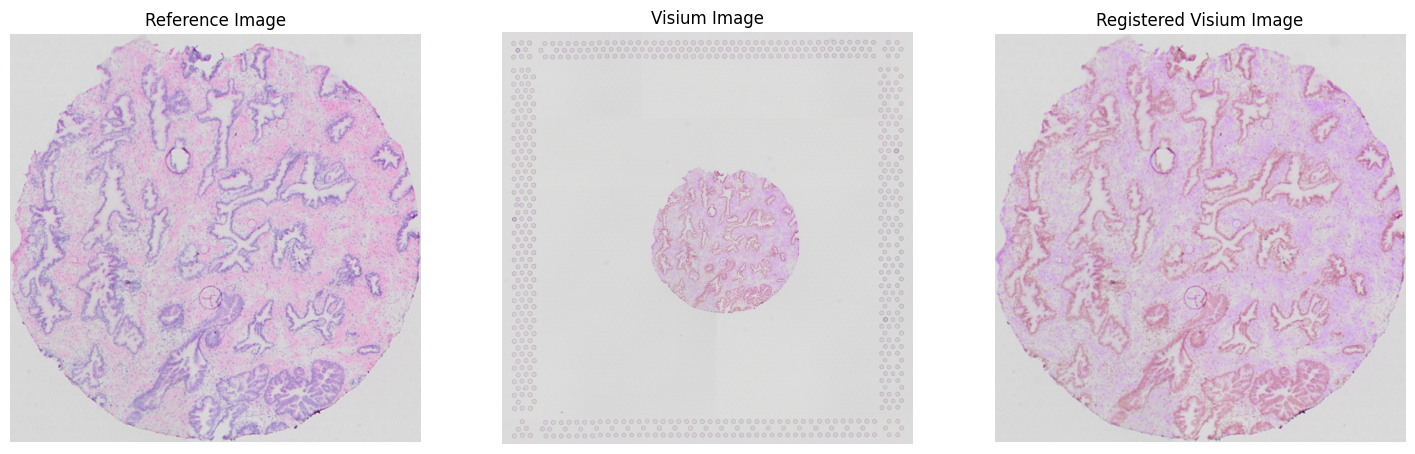

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(section.reference_image.data)
axs[0].set_title('Reference Image')
axs[1].imshow(st_data.image.data)
axs[1].set_title('Visium Image')
axs[2].imshow(registered_image)
axs[2].set_title('Registered Visium Image')

In [13]:
# Now that st data is registered, we can add it to sections.
section.so_data.append(warped_st_data)

In [14]:
# We also provide a summary function that lists all additional imaging data in a section.
section.print_additional_data_summary()

#########################################################################
# Name              # ID                                   # Type       #
#########################################################################
# tissue_mask       # 864b7f5e-6126-11ef-b9b6-fa163eee643f # annotation #
# histo_annotations # 86c0cb38-6126-11ef-b9b6-fa163eee643f # annotation #
# landmarks         # 86f4e3dc-6126-11ef-b9b6-fa163eee643f # pointset   #
#                   # 923812e6-6126-11ef-b9b6-fa163eee643f # visium     #
#########################################################################


BaseImaging objects support a few basic image operation (see source code for now).

### Loading MSI data

In the next example we show how to load msi data. We use the imzML format for handling msi data.

In [15]:
# We start out by simply using a classmethod for initializing imzml data

msi_hist_image_path = '../data/hist/section3/reference_image.tif'
msi_hist_image = DefaultImage(data=sitk.GetArrayFromImage(sitk.ReadImage(msi_hist_image_path)))
imzml_path = '../data/msi_neg/data.imzML'


imzml_neg_1 = Imzml.load_msi_data(msi_hist_image,
                                  imzml_path,
                                  name='negative ion mode')

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


In [16]:
# We now show a detailled example of how to load msi data.

# First, we convert the msi data from the imzml format to a spatial matrix like format
# We can also provide annotation in srd format.
from miit.spatial_data.spatial_omics.imzml import convert_to_matrix

target_resolution = 1
msi_neg = pyimzml.ImzMLParser.ImzMLParser(imzml_path)

ref_mat, spec_to_ref_map, _ = convert_to_matrix(msi_neg, target_resolution=1)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'MSI-Pixel distribution')

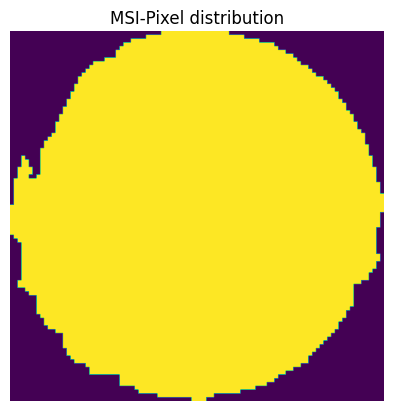

In [17]:
# The return of the conversion are a ref_mat, which is a matrix representation of the spatial distribution of 
# msi-pixels. spec_to_ref_map contains the mapping from each reference in `ref_mat` to its original msi-pixel.
# This mapping will be used internally in Imzml objects during integration.
plt.imshow(ref_mat > 0)
plt.axis('off')
plt.title('MSI-Pixel distribution')

(-0.5, 2963.5, 2962.5, -0.5)

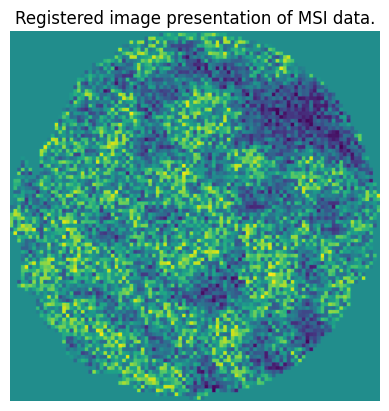

In [18]:
# Now, msi data might be offset a little bit from the histology image. For this case, we have a separate registration algorithm.
# By default, we use NiftyReg as a registration algorithm, though others can be supplied as well.
# For the registration, we derive an image presentation based on the PCA spectrum.
# We supply the ref_mat, so that the data can be transformed directly in the function.
from miit.spatial_data.spatial_omics.imzml import do_msi_registration

registered_image, ref_mat, add_imgs = do_msi_registration(msi_hist_image.data, 
                                           ref_mat, 
                                           spec_to_ref_map, 
                                           msi_neg)
ref_mat = ref_mat.astype(int)
                                           
plt.imshow(registered_image)
plt.title('Registered image presentation of MSI data.')
plt.axis('off')

In [19]:
# We now wrap the registered ref_mat in an Annotation and load the Imzml object.
imzml = Imzml(image=msi_hist_image, spec_to_ref_map=spec_to_ref_map)
imzml.ref_mat = ref_mat

In [20]:
section2 = Section()
section2.reference_image = msi_hist_image
section2.so_data.append(imzml)

section2.print_additional_data_summary()

#######################################################
# Name # ID                                   # Type  #
#######################################################
#      # b587ec08-6126-11ef-b9b6-fa163eee643f # Imzml #
#######################################################


### Storing and loading sections

MIIT has support for loading and storing imaging data types.

In [21]:
section.store('../data/tmp_store')

{'id': '881ece44-6126-11ef-b9b6-fa163eee643f', 'name': None, 'reference_image': {'id': '8596f098-6126-11ef-b9b6-fa163eee643f', 'type': 'default_image'}, 'meta_information_path': 'meta_information.json', 'annotations': [{'id': '864b7f5e-6126-11ef-b9b6-fa163eee643f', 'type': 'annotation'}, {'id': '86c0cb38-6126-11ef-b9b6-fa163eee643f', 'type': 'annotation'}, {'id': '86f4e3dc-6126-11ef-b9b6-fa163eee643f', 'type': 'pointset'}], 'so_datas': [{'id': '923812e6-6126-11ef-b9b6-fa163eee643f', 'type': 'visium'}]}


The output should look something that. This format is somewhat human readable. In `attributes.json` the mapping of each imaging type to `uuid` is documented.

```
.
├── 6b4e8faa-3a13-11ef-b22b-fa163eee643f
│   ├── attributes.json
│   └── image.nii.gz
├── 6b56c558-3a13-11ef-b22b-fa163eee643f
│   ├── additional_attributes.json
│   └── annotations.nii.gz
├── 6bad2006-3a13-11ef-b22b-fa163eee643f
│   ├── additional_attributes.json
│   ├── annotations.nii.gz
│   └── labels.txt
├── 6bd4a5c2-3a13-11ef-b22b-fa163eee643f
│   ├── attributes.json
│   └── pointset.csv
├── 9bfdbd06-3a13-11ef-b22b-fa163eee643f
│   ├── 74049144-3a13-11ef-b22b-fa163eee643f
│   │   ├── attributes.json
│   │   └── image.nii.gz
│   ├── 9bfd4ede-3a13-11ef-b22b-fa163eee643f
│   │   ├── additional_attributes.json
│   │   └── annotations.nii.gz
│   ├── 9bfdb9c8-3a13-11ef-b22b-fa163eee643f
│   │   ├── attributes.json
│   │   └── pointset.csv
│   ├── attributes.json
│   ├── config.json
│   ├── scale_factors.json
│   ├── spec_to_ref_mat.json
│   └── spot_scaling_journal.csv
├── attributes.json
└── meta_information.json
```

In [22]:
# Similarly, the data can be loaded using the load function.

loaded_section = Section.load('../data/tmp_store/')

### Adding new data types.

MIIT has support for adding new data types. For basic imaging types, we can add new data types by implementing either the `BaseImaging` or `BasePointset` interfaces. For
spatial omics datatypes that are more complex, the `BaseSpatialOmics` interface can be implemented.

If storing and loading of new datatypes should be supported, the new dataypes can be added to the `SpatialDataLoader` class. (example to follow soon.)